<a href="https://colab.research.google.com/github/Focal-QuantAI/QuantAI-Blog/blob/stage/Based_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Trading Strategy Benchmarking Notebook

  

## Overview

This notebook provides a comprehensive framework for testing and evaluating algorithmic trading strategies on Nifty 250 stocks. The benchmarking process involves fetching historical data, running backtests across multiple random episodes,  and performing statistical analysis to evaluate strategy performance.




## Table of Contents

1. [Setup and Configuration](#setup-and-configuration)

2. [Strategy Definition](#strategy-definition)

3. [Data Collection](#data-collection)

4. [Episode Generation](#episode-generation)

5. [Backtesting Engine](#backtesting-engine)

6. [Results Collection](#results-collection)

7. [Statistical Analysis](#statistical-analysis)

8. [Performance Visualization](#performance-visualization)

9. [Summary Report](#summary-report)



In [ ]:
# Install required packages (run once)
!pip -qq install yfinance backtesting pandas numpy matplotlib seaborn scipy plotly

In [ ]:


### Import Libraries

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import random
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from tqdm.auto import tqdm
import pickle
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
random.seed(42)
np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [ ]:
### Configuration Parameters
# Benchmarking Configuration
data_period= '3y' #@param["1y", "2y", "3y"]
num_stocks=60 #@param
num_episodes= 60 #@param
min_episode_days= 30 #@param
max_episode_days= 180 #@param
initial_cash= 100000 #@param
commission= 0.001 #@param
save_results= True #@param
results_dir= 'benchmark_results'#@param


CONFIG = {
  'data_period':data_period,
  'num_stocks':num_stocks,
  'num_episodes':num_episodes,
  'min_episode_days':min_episode_days,
  'max_episode_days':max_episode_days,
  'initial_cash':initial_cash,
  'commission':commission,
  'save_results':save_results,
  'results_dir':results_dir,
}

print("Configuration loaded successfully!")
print(f"Will test on {CONFIG['num_stocks']} stocks with {CONFIG['num_episodes']} episodes each")


Configuration loaded successfully!
Will test on 60 stocks with 60 episodes each


## 2. Strategy Definition

  

### 🔧 USER INPUT SECTION - Strategy Implementation

**Instructions:** Replace the placeholder strategy below with your custom algorithm. The strategy class should inherit from `backtesting.Strategy` and implement the `init()` and `next()` methods.


In [ ]:

class  UserStrategy(Strategy):
  """
  USER ALGORITHM IMPLEMENTATION
  Replace this placeholder with your custom trading strategy.
  Example structure:
  - Use self.init() to initialize indicators
  - Use self.next() to implement trading logic
  - Use self.buy() and self.sell() for trade execution
    """
  # Strategy parameters (modify as needed)
  fast_ma = 5
  slow_ma = 8
  def  init(self):
    """Initialize indicators and variables"""
    # Example: Moving averages
    close = self.data.Close
    self.ma_fast = self.I(lambda x: pd.Series(x).rolling(self.fast_ma).mean(), close)
    self.ma_slow = self.I(lambda x: pd.Series(x).rolling(self.slow_ma).mean(), close)
    # Add your custom indicators here
    # self.custom_indicator = self.I(your_indicator_function, self.data.Close)
  def  next(self):
    """Trading logic executed for each bar"""
  # Example: Simple moving average crossover
    if crossover(self.ma_fast,  self.ma_slow):
      self.buy()
    elif crossover(self.ma_slow,  self.ma_fast):
      self.sell()
    # Implement your custom trading logic here
    # if your_buy_condition:
    # self.buy()
    # elif your_sell_condition:
    # self.sell()

print("Strategy class defined successfully!")


Strategy class defined successfully!



### 📝 USER INPUT SECTION - Strategy Description

**Instructions:** Provide a detailed description of your trading strategy, including the logic, indicators used,  and expected market conditions.

  

In [ ]:

STRATEGY_DESCRIPTION = """
STRATEGY NAME: [Enter your strategy name]

STRATEGY DESCRIPTION:
[Provide a detailed description of your algorithm including:]
- Main trading logic and rules
- Technical indicators used
- Entry and exit conditions
- Risk management approach
- Expected market conditions where strategy performs well
- Any assumptions or limitations

  PARAMETERS:
[List key parameters and their values]
- Parameter 1: Value
- Parameter 2: Value

  EXPECTED PERFORMANCE:
[Your hypothesis about strategy performance]
"""

print("Strategy description loaded!")
print("\n" + "="*60)
print("STRATEGY OVERVIEW")
print("="*60)
print(STRATEGY_DESCRIPTION)


Strategy description loaded!

STRATEGY OVERVIEW

STRATEGY NAME: [Enter your strategy name]
  
STRATEGY DESCRIPTION:
[Provide a detailed description of your algorithm including:]
- Main trading logic and rules
- Technical indicators used
- Entry and exit conditions
- Risk management approach
- Expected market conditions where strategy performs well
- Any assumptions or limitations
  
  PARAMETERS:
[List key parameters and their values]
- Parameter 1: Value
- Parameter 2: Value
  
  EXPECTED PERFORMANCE:
[Your hypothesis about strategy performance]



## 3. Data Collection
### Fetch Stock List


In [ ]:
import requests

def  get_stock_symbols(stock_list):

  base_url = 'https://www.niftyindices.com/IndexConstituent/'

  stock_map = {
      'NIFTY250':'ind_niftysmallcap250list.csv',
      'NIFTY50':'ind_nifty50list.csv',
  }

  content = requests.get(
      f'{base_url}{stock_map.get(stock_list)}',
      headers={'User-Agent': 'Mozilla/5.0'}
      ).text

  with open('tmp.csv', 'w') as f:
    f.write(content)

  df = pd.read_csv(f'tmp.csv')

  stocks = (df.Symbol+'.NS').tolist()
  return stocks

stock_list = 'NIFTY250' #@param["NIFTY250", "NIFTY50"]

stock_symbols = get_stock_symbols(stock_list)
print(f"Loaded {len(stock_symbols)} stock symbols")

# Randomly select stocks for testing
selected_stocks = random.sample(stock_symbols,  min(CONFIG['num_stocks'],  len(stock_symbols)))
print(f"Selected {len(selected_stocks)} stocks for benchmarking")

Loaded 251 stock symbols
Selected 60 stocks for benchmarking


In [ ]:

### Data Fetching Function
def  fetch_stock_data(symbol, period='2y'):
  """Fetch historical stock data from yfinance"""
  try:
    ticker = yf.Ticker(symbol)
    data = ticker.history(period=period)
    if  len(data) < 100:  # Minimum data requirement
      return  None
    # Clean data
    data = data.dropna()
    data.index = pd.to_datetime(data.index)
    return data
  except Exception as e:
    print(f"Error fetching data for {symbol}: {e}")
  return  None

def  fetch_all_data(symbols):
  """Fetch data for all selected symbols"""
  stock_data = {}
  failed_symbols = []
  print("Fetching stock data...")
  for symbol in tqdm(symbols):
    data = fetch_stock_data(symbol, CONFIG['data_period'])
    if data is not None:
      stock_data[symbol] = data
    else:
      failed_symbols.append(symbol)
  time.sleep(0.1)
  print(f"Successfully fetched data for {len(stock_data)} stocks")
  if failed_symbols:
    print(f"Failed to fetch data for: {failed_symbols}")
  return stock_data

# Fetch all stock data
all_stock_data = fetch_all_data(selected_stocks)

all_stock_data[sorted(list(all_stock_data))[0]].head()

Fetching stock data...


  0%|          | 0/60 [00:00<?, ?it/s]

Successfully fetched data for 60 stocks


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-15 00:00:00+05:30,315.000000,343.700012,292.000000,329.450012,71401006,0.0,0.0
2024-05-16 00:00:00+05:30,342.500000,362.350006,341.000000,361.100006,26767907,0.0,0.0
2024-05-17 00:00:00+05:30,365.000000,371.299988,345.200012,351.149994,11970918,0.0,0.0
2024-05-21 00:00:00+05:30,345.100006,349.700012,337.000000,342.700012,3451610,0.0,0.0
2024-05-22 00:00:00+05:30,342.049988,348.750000,336.000000,343.350006,2578275,0.0,0.0


## 4. Episode Generation

### Episode Generation Functions


In [ ]:

def  generate_random_episodes(data, num_episodes, min_days, max_days):
  """Generate random time periods (episodes) from the data"""
  episodes = []
  total_days = len(data)
  if total_days < max_days:
    print(f"Warning: Data has only {total_days} days, adjusting episode parameters")
  max_days = min(max_days, total_days - 10)
  min_days = min(min_days, max_days)
  for i in  range(num_episodes):
    # Random episode length
    episode_length = random.randint(min_days, max_days)
    # Random start position
    max_start = total_days - episode_length
    if max_start <= 0:
      continue
    start_idx = random.randint(0, max_start)
    end_idx = start_idx + episode_length
    episode_data = data.iloc[start_idx:end_idx].copy()
    episodes.append(
        {
          'episode_id':  f"ep_{i+1:03d}",
          'start_date': episode_data.index[0],
          'end_date': episode_data.index[-1],
          'duration_days':  len(episode_data),
          'data': episode_data
        }
    )
  return episodes

def  generate_all_episodes():
  """Generate episodes for all stocks"""
  all_episodes = {}
  print("Generating random episodes for all stocks...")
  for symbol, data in tqdm(all_stock_data.items()):
    episodes = generate_random_episodes(
      data,
      CONFIG['num_episodes'],
      CONFIG['min_episode_days'],
      CONFIG['max_episode_days']
    )
    all_episodes[symbol] = episodes
  total_episodes = sum(len(episodes)  for episodes in all_episodes.values())
  print(f"Generated {total_episodes} total episodes across {len(all_episodes)} stocks")
  return all_episodes

  # Generate all episodes
episode_data = generate_all_episodes()
len(episode_data)

Generating random episodes for all stocks...


  0%|          | 0/60 [00:00<?, ?it/s]

Generated 3600 total episodes across 60 stocks


60

## 5. Backtesting Engine
### Backtesting Functions

In [ ]:
def  run_single_backtest(data, strategy_class):
  """Run backtest on a single episode"""
  try:
    bt = Backtest(
      data,
      strategy_class,
      cash=CONFIG['initial_cash'],
      commission=CONFIG['commission'],
      exclusive_orders=True
    )
    result = bt.run()
    return result, bt
  except Exception as e:
    print(f"Backtest error: {e}")
  return  None,  None

def extract_trade_metrics(result):
  """Extract relevant metrics from backtest result"""
  if result is  None:
    return  None
  metrics = {
    'return_pct': result['Return [%]'],
    'buy_hold_return_pct': result['Buy & Hold Return [%]'],
    'num_trades': result['# Trades'],
    'win_rate_pct': result['Win Rate [%]'],
    'best_trade_pct': result['Best Trade [%]'],
    'worst_trade_pct': result['Worst Trade [%]'],
    'avg_trade_pct': result['Avg. Trade [%]'],
    'max_drawdown_pct': result['Max. Drawdown [%]'],
    'sharpe_ratio': result['Sharpe Ratio'],
    'sortino_ratio': result['Sortino Ratio'],
    'calmar_ratio': result['Calmar Ratio'],
    'final_equity': result['Equity Final [$]'],
    'exposure_time_pct': result['Exposure Time [%]']
  }
  return metrics

def  run_all_backtests():
  """Run backtests on all episodes"""
  all_results = []
  failed_tests = 0
  print("Running backtests on all episodes...")
  for symbol, episodes in all_stock_data.items():
    print(f"Processing {symbol}...")
    for episode in tqdm(episode_data[symbol]):
      result, bt = run_single_backtest(episode['data'], UserStrategy)
    if result is  not  None:
      metrics = extract_trade_metrics(result)
      if metrics is  not  None:
        test_record = {
        'symbol': symbol,
        'episode_id': episode['episode_id'],
        'start_date': episode['start_date'],
        'end_date': episode['end_date'],
        'duration_days': episode['duration_days'],
        **metrics
        }
        all_results.append(test_record)
      else:
        failed_tests += 1
    else:
      failed_tests += 1
  print(f"\nCompleted backtesting!")
  print(f"Successful tests: {len(all_results)}")
  print(f"Failed tests: {failed_tests}")
  return pd.DataFrame(all_results)

  # Run all backtests
print("Starting comprehensive backtesting process...")
backtest_results = run_all_backtests()
backtest_results

## 6. Results Collection

### Save and Load Results


In [ ]:
def save_results(results_df, strategy_name="user_strategy"):
    """Save results to file"""
    if CONFIG['save_results']:
        os.makedirs(CONFIG['results_dir'], exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{CONFIG['results_dir']}/{strategy_name}_{timestamp}.csv"

        results_df.to_csv(filename, index=False)
        print(f"Results saved to: {filename}")

        # Also save as pickle for Python objects
        pickle_filename = f"{CONFIG['results_dir']}/{strategy_name}_{timestamp}.pkl"
        with open(pickle_filename, 'wb') as f:
            pickle.dump({
                'results': results_df,
                'config': CONFIG,
                'strategy_description': STRATEGY_DESCRIPTION
            }, f)
        print(f"Full results saved to: {pickle_filename}")

# Save results
if len(backtest_results) > 0:
    save_results(backtest_results)
    print(f"\nResults Overview:")
    print(f"Total Episodes Tested: {len(backtest_results)}")
    print(f"Unique Stocks: {backtest_results['symbol'].nunique()}")
    print(f"Date Range: {backtest_results['start_date'].min()} to {backtest_results['end_date'].max()}")
else:
    print("No results to save - all backtests failed!")

Results saved to: benchmark_results/user_strategy_20250603_111619.csv
Full results saved to: benchmark_results/user_strategy_20250603_111619.pkl

Results Overview:
Total Episodes Tested: 60
Unique Stocks: 60
Date Range: 2022-07-22 00:00:00+05:30 to 2025-05-29 00:00:00+05:30


## Statistical Analysis

#### Comprehensive Statistical Analysis

In [ ]:
def perform_statistical_analysis(results_df):
    """Perform comprehensive statistical analysis"""
    if len(results_df) == 0:
        print("No data available for analysis")
        return None

    print("="*60)
    print("STATISTICAL ANALYSIS REPORT")
    print("="*60)

    # Basic Statistics
    print("\n1. BASIC PERFORMANCE STATISTICS")
    print("-" * 40)

    key_metrics = ['return_pct', 'win_rate_pct', 'sharpe_ratio', 'max_drawdown_pct', 'num_trades']
    basic_stats = results_df[key_metrics].describe()
    print(basic_stats.round(2))

    # Performance vs Buy & Hold
    print("\n2. STRATEGY vs BUY & HOLD COMPARISON")
    print("-" * 40)
    outperformed = (results_df['return_pct'] > results_df['buy_hold_return_pct']).sum()
    total_episodes = len(results_df)
    outperform_rate = (outperformed / total_episodes) * 100

    print(f"Episodes where strategy outperformed Buy & Hold: {outperformed}/{total_episodes} ({outperform_rate:.1f}%)")
    print(f"Average strategy return: {results_df['return_pct'].mean():.2f}%")
    print(f"Average buy & hold return: {results_df['buy_hold_return_pct'].mean():.2f}%")
    print(f"Average excess return: {(results_df['return_pct'] - results_df['buy_hold_return_pct']).mean():.2f}%")

    # Risk Metrics
    print("\n3. RISK ANALYSIS")
    print("-" * 40)
    print(f"Average Maximum Drawdown: {results_df['max_drawdown_pct'].mean():.2f}%")
    print(f"Worst Maximum Drawdown: {results_df['max_drawdown_pct'].min():.2f}%")
    print(f"Average Sharpe Ratio: {results_df['sharpe_ratio'].mean():.2f}")
    print(f"Average Sortino Ratio: {results_df['sortino_ratio'].mean():.2f}")

    # Trading Activity
    print("\n4. TRADING ACTIVITY ANALYSIS")
    print("-" * 40)
    print(f"Average Number of Trades per Episode: {results_df['num_trades'].mean():.1f}")
    print(f"Average Win Rate: {results_df['win_rate_pct'].mean():.1f}%")
    print(f"Average Trade Return: {results_df['avg_trade_pct'].mean():.2f}%")
    print(f"Best Single Trade: {results_df['best_trade_pct'].max():.2f}%")
    print(f"Worst Single Trade: {results_df['worst_trade_pct'].min():.2f}%")

    # Statistical Tests
    print("\n5. STATISTICAL SIGNIFICANCE TESTS")
    print("-" * 40)

    # Test if returns are significantly different from zero
    t_stat, p_value = stats.ttest_1samp(results_df['return_pct'], 0)
    print(f"T-test (returns vs 0): t-statistic = {t_stat:.3f}, p-value = {p_value:.6f}")

    # Test if strategy returns are significantly different from buy & hold
    excess_returns = results_df['return_pct'] - results_df['buy_hold_return_pct']
    t_stat_excess, p_value_excess = stats.ttest_1samp(excess_returns, 0)
    print(f"T-test (excess returns vs 0): t-statistic = {t_stat_excess:.3f}, p-value = {p_value_excess:.6f}")

    # Distribution analysis
    print("\n6. RETURN DISTRIBUTION ANALYSIS")
    print("-" * 40)
    returns = results_df['return_pct']
    print(f"Skewness: {stats.skew(returns):.3f}")
    print(f"Kurtosis: {stats.kurtosis(returns):.3f}")
    print(f"Positive return episodes: {(returns > 0).sum()}/{len(returns)} ({(returns > 0).mean()*100:.1f}%)")

    # Performance by stock
    print("\n7. PERFORMANCE BY STOCK")
    print("-" * 40)
    stock_performance = results_df.groupby('symbol')['return_pct'].agg(['mean', 'std', 'count']).round(2)
    print("Top 10 performing stocks (by average return):")
    print(stock_performance.sort_values('mean', ascending=False).head(10))

    return {
        'basic_stats': basic_stats,
        'outperform_rate': outperform_rate,
        'excess_returns': excess_returns,
        'statistical_tests': {
            't_stat': t_stat,
            'p_value': p_value,
            't_stat_excess': t_stat_excess,
            'p_value_excess': p_value_excess
        }
    }

# Perform analysis
if len(backtest_results) > 0:
    analysis_results = perform_statistical_analysis(backtest_results)
else:
    print("No results available for statistical analysis")

STATISTICAL ANALYSIS REPORT

1. BASIC PERFORMANCE STATISTICS
----------------------------------------
       return_pct  win_rate_pct  sharpe_ratio  max_drawdown_pct  num_trades
count       60.00         60.00         60.00             60.00       60.00
mean        -6.12         38.14         -1.24            -26.11       13.62
std         22.50         14.44          1.94             13.53        6.15
min        -56.55          0.00         -6.73            -65.91        2.00
25%        -20.32         26.70         -2.43            -34.97        9.75
50%         -7.69         41.18         -0.92            -23.38       14.50
75%          6.58         50.00          0.37            -14.60       18.00
max         54.76         69.23          1.30             -6.29       25.00

2. STRATEGY vs BUY & HOLD COMPARISON
----------------------------------------
Episodes where strategy outperformed Buy & Hold: 16/60 (26.7%)
Average strategy return: -6.12%
Average buy & hold return: 15.33%
Averag

## 8. Performance Visualization

####Comprehensive Visualization Suite

Creating performance visualizations...


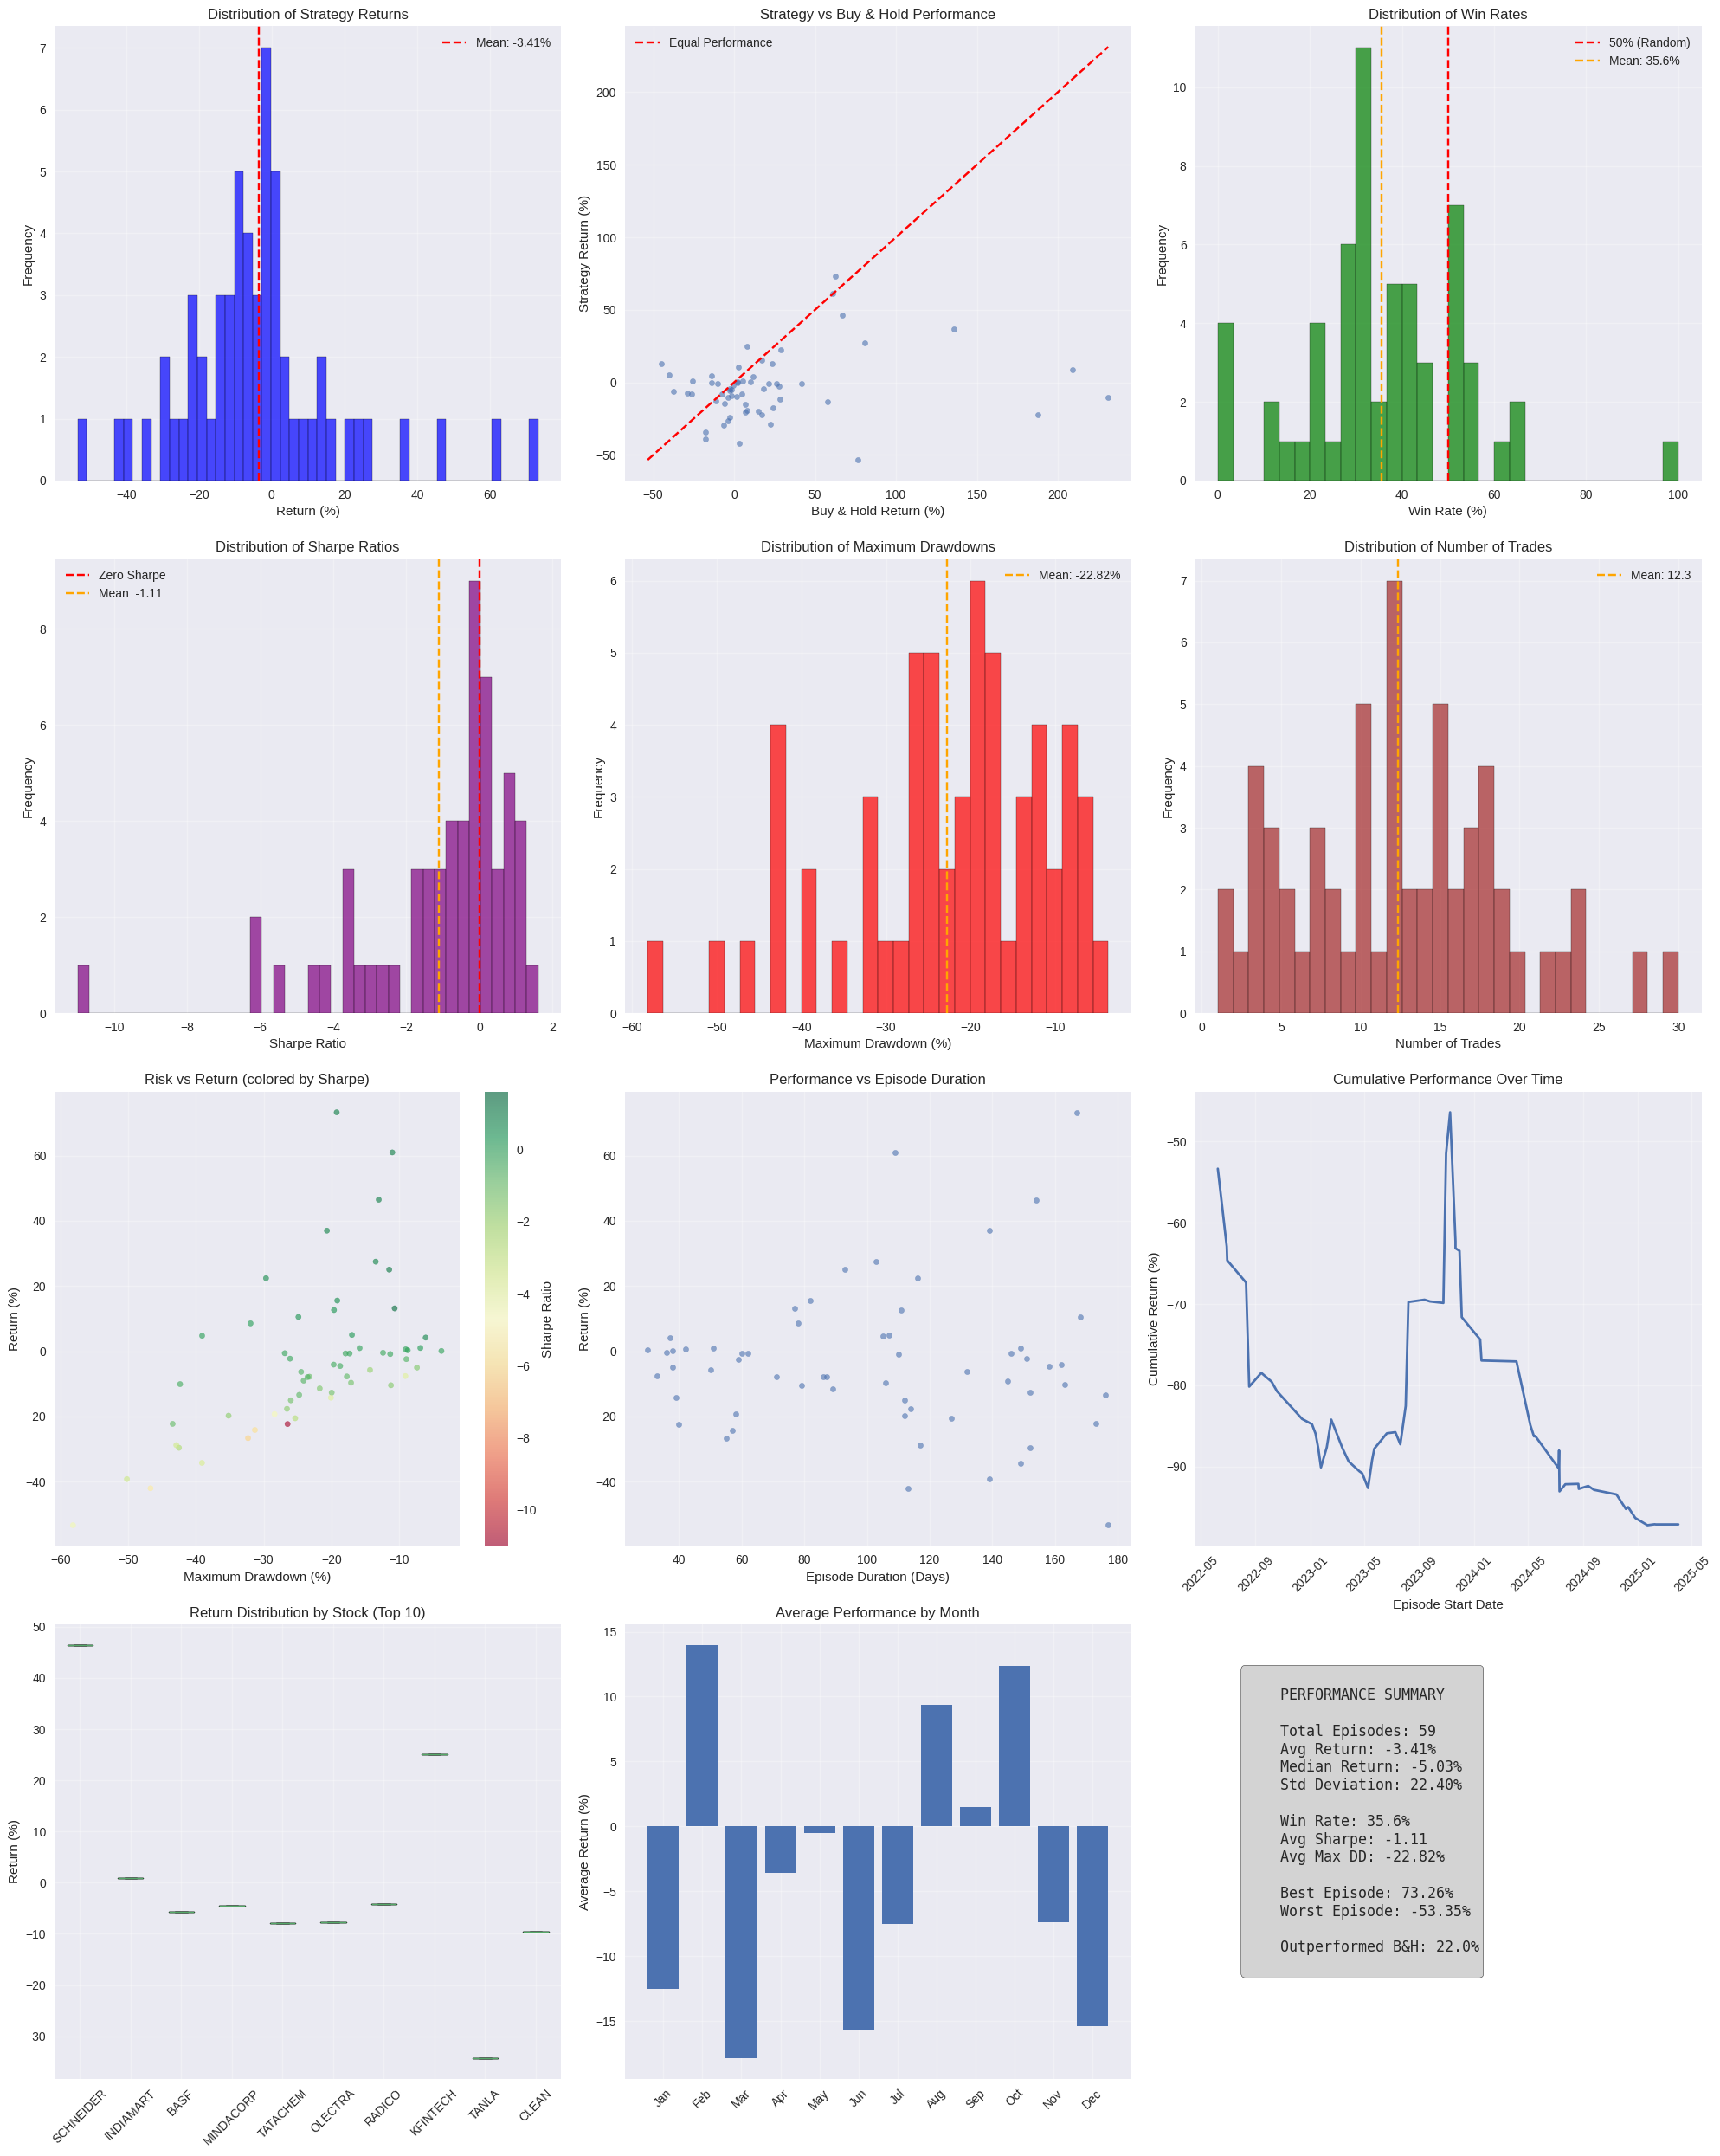

In [ ]:
def create_performance_visualizations(results_df):
    """Create comprehensive performance visualizations"""
    if len(results_df) == 0:
        print("No data available for visualization")
        return

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 25))

    print("Creating performance visualizations...")

    # 1. Return Distribution
    plt.subplot(4, 3, 1)
    plt.hist(results_df['return_pct'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(results_df['return_pct'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["return_pct"].mean():.2f}%')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Strategy Returns')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Strategy vs Buy & Hold
    plt.subplot(4, 3, 2)
    plt.scatter(results_df['buy_hold_return_pct'], results_df['return_pct'], alpha=0.6, s=20)
    # Add diagonal line (y=x)
    min_val = min(results_df['buy_hold_return_pct'].min(), results_df['return_pct'].min())
    max_val = max(results_df['buy_hold_return_pct'].max(), results_df['return_pct'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Equal Performance')
    plt.xlabel('Buy & Hold Return (%)')
    plt.ylabel('Strategy Return (%)')
    plt.title('Strategy vs Buy & Hold Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Win Rate Distribution
    plt.subplot(4, 3, 3)
    plt.hist(results_df['win_rate_pct'], bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(50, color='red', linestyle='--', label='50% (Random)')
    plt.axvline(results_df['win_rate_pct'].mean(), color='orange', linestyle='--',
                label=f'Mean: {results_df["win_rate_pct"].mean():.1f}%')
    plt.xlabel('Win Rate (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Win Rates')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Sharpe Ratio Distribution
    plt.subplot(4, 3, 4)
    sharpe_clean = results_df['sharpe_ratio'].replace([np.inf, -np.inf], np.nan).dropna()
    plt.hist(sharpe_clean, bins=40, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', label='Zero Sharpe')
    plt.axvline(sharpe_clean.mean(), color='orange', linestyle='--',
                label=f'Mean: {sharpe_clean.mean():.2f}')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sharpe Ratios')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Maximum Drawdown
    plt.subplot(4, 3, 5)
    plt.hist(results_df['max_drawdown_pct'], bins=30, alpha=0.7, color='red', edgecolor='black')
    plt.axvline(results_df['max_drawdown_pct'].mean(), color='orange', linestyle='--',
                label=f'Mean: {results_df["max_drawdown_pct"].mean():.2f}%')
    plt.xlabel('Maximum Drawdown (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Maximum Drawdowns')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Number of Trades
    plt.subplot(4, 3, 6)
    plt.hist(results_df['num_trades'], bins=30, alpha=0.7, color='brown', edgecolor='black')
    plt.axvline(results_df['num_trades'].mean(), color='orange', linestyle='--',
                label=f'Mean: {results_df["num_trades"].mean():.1f}')
    plt.xlabel('Number of Trades')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Trades')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 7. Return vs Risk (Sharpe) Scatter
    plt.subplot(4, 3, 7)
    sharpe_clean = results_df['sharpe_ratio'].replace([np.inf, -np.inf], np.nan)
    valid_data = results_df[sharpe_clean.notna()]
    plt.scatter(valid_data['max_drawdown_pct'], valid_data['return_pct'],
                c=valid_data['sharpe_ratio'], cmap='RdYlGn', alpha=0.6, s=20)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Maximum Drawdown (%)')
    plt.ylabel('Return (%)')
    plt.title('Risk vs Return (colored by Sharpe)')
    plt.grid(True, alpha=0.3)

    # 8. Performance by Episode Duration
    plt.subplot(4, 3, 8)
    plt.scatter(results_df['duration_days'], results_df['return_pct'], alpha=0.6, s=20)
    plt.xlabel('Episode Duration (Days)')
    plt.ylabel('Return (%)')
    plt.title('Performance vs Episode Duration')
    plt.grid(True, alpha=0.3)

    # 9. Cumulative Performance Over Time
    plt.subplot(4, 3, 9)
    # Sort by start date and calculate cumulative returns
    results_sorted = results_df.sort_values('start_date')
    cumulative_returns = (1 + results_sorted['return_pct']/100).cumprod() - 1
    plt.plot(results_sorted['start_date'], cumulative_returns * 100, linewidth=2)
    plt.xlabel('Episode Start Date')
    plt.ylabel('Cumulative Return (%)')
    plt.title('Cumulative Performance Over Time')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 10. Box plot of returns by stock (top 10 stocks)
    plt.subplot(4, 3, 10)
    top_stocks = results_df['symbol'].value_counts().head(10).index
    stock_returns = [results_df[results_df['symbol'] == stock]['return_pct']
                    for stock in top_stocks]
    plt.boxplot(stock_returns, labels=[s.replace('.NS', '') for s in top_stocks])
    plt.xticks(rotation=45)
    plt.ylabel('Return (%)')
    plt.title('Return Distribution by Stock (Top 10)')
    plt.grid(True, alpha=0.3)

    # 11. Monthly Performance Heatmap
    plt.subplot(4, 3, 11)
    results_df['start_month'] = results_df['start_date'].dt.month
    monthly_returns = results_df.groupby('start_month')['return_pct'].mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.bar(range(1, 13), [monthly_returns.get(i, 0) for i in range(1, 13)])
    plt.xticks(range(1, 13), months, rotation=45)
    plt.ylabel('Average Return (%)')
    plt.title('Average Performance by Month')
    plt.grid(True, alpha=0.3)

    # 12. Performance Summary Table (as text)
    plt.subplot(4, 3, 12)
    plt.axis('off')
    summary_text = f"""
    PERFORMANCE SUMMARY

    Total Episodes: {len(results_df):,}
    Avg Return: {results_df['return_pct'].mean():.2f}%
    Median Return: {results_df['return_pct'].median():.2f}%
    Std Deviation: {results_df['return_pct'].std():.2f}%

    Win Rate: {results_df['win_rate_pct'].mean():.1f}%
    Avg Sharpe: {results_df['sharpe_ratio'].mean():.2f}
    Avg Max DD: {results_df['max_drawdown_pct'].mean():.2f}%

    Best Episode: {results_df['return_pct'].max():.2f}%
    Worst Episode: {results_df['return_pct'].min():.2f}%

    Outperformed B&H: {((results_df['return_pct'] > results_df['buy_hold_return_pct']).sum() / len(results_df) * 100):.1f}%
    """
    plt.text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top',
             fontfamily='monospace', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    plt.tight_layout()
    plt.show()

create_performance_visualizations(backtest_results)
